In [1]:
# Disable Output Wrapping
from IPython.core.display import display, HTML
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0 sparknlp seaborn spacy

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

/tmp/ipykernel_299/3341157910.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML





## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - conda-forge/openjdk/11.0.1/download/linux-64::openjdk==11.0.1=hacce0ff_1021


The following NEW packages will be INSTALLED:

  openjdk            conda-forge/openjdk/11.0.1/download/linux-64::openjdk-11.0.1-hacce0ff_1021 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
  Using cached pyspark-3.4.0-py2.py3-none-any.whl
  Using cached sparknlp-1.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached spacy-3.8.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached spark_nlp-5.5.1-py2.py3-none-any.whl.metadata (19 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.11-cp311

In [2]:
# Correct Spark session setup with both packages in a single line
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkNLPApp")
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.3,org.apache.hadoop:hadoop-aws:3.2.2")
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")
    .getOrCreate()
)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d36fe326-ee70-4eae-bc37-9a81003339d4;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found i

In [3]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
# set up S3 paths
aita_filtered_path = f"s3a://{bucket}/BDproject/aita.parquet"
aio_filtered_path = f"s3a://{bucket}/BDproject/aio.parquet"
ask_reddit_filtered_path = f"s3a://{bucket}/BDproject/ask_reddit.parquet"
posts_filtered_path = f"s3a://{bucket}/BDproject/posts.parquet"

# aita_comments_path = f"s3a://{bucket}/BDproject/aita_comments.parquet"
# aio_comments_path = f"s3a://{bucket}/BDproject/aio_comments.parquet"
# ask_reddit_comments_path = f"s3a://{bucket}/BDproject/ask_reddit_comments.parquet"


# Read the Parquet files from S3
aita_df = spark.read.parquet(aita_filtered_path)
aio_df = spark.read.parquet(aio_filtered_path)
ask_reddit_df = spark.read.parquet(ask_reddit_filtered_path)
posts_df = spark.read.parquet(posts_filtered_path)

aita_df = aita_df.filter((aita_df.post_id.isNotNull()) & (aita_df.selftext != "[deleted]"))
aio_df = aio_df.filter((aio_df.post_id.isNotNull()) & (aio_df.selftext != "[deleted]"))
ask_reddit_df = ask_reddit_df.filter((ask_reddit_df.post_id.isNotNull()) & (ask_reddit_df.selftext != "[deleted]"))

24/12/08 16:09:26 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [5]:
%%time
aita_meta_pd = aita_df.select('post_id','created_utc_post','score_post','num_comments','over_18').distinct().toPandas()
aio_meta_pd = aio_df.select('post_id','created_utc_post','score_post','num_comments','over_18').distinct().toPandas()
ask_meta_pd = ask_reddit_df.select('post_id','created_utc_post','score_post','num_comments','over_18').distinct().toPandas()

CPU times: user 425 ms, sys: 11.5 ms, total: 437 ms
Wall time: 1min 2s


In [6]:
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, StopWordsCleaner, Normalizer, LemmatizerModel, Stemmer
from pyspark.ml import Pipeline
from sparknlp import annotator
from pyspark.sql.functions import concat_ws, regexp_replace

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import concat_ws

# DocumentAssembler to convert text into Spark NLP's Document format
document_assembler = DocumentAssembler() \
    .setInputCol("selftext") \
    .setOutputCol("document")

# Tokenize the text
tokenizer = annotator.Tokenizer() \
    .setInputCols("document") \
    .setOutputCol("token")

# Remove stop words
stop_words_cleaner = StopWordsCleaner() \
    .setInputCols("token") \
    .setOutputCol("cleaned_token") \
    .setCaseSensitive(False)

# Normalize tokens (remove unusual characters)
normalizer = Normalizer() \
    .setInputCols("cleaned_token") \
    .setOutputCol("normalized") \
    .setLowercase(True) \
    .setCleanupPatterns(["[^a-zA-Z]"])  # removes non-alphabetical characters

# Lemmatize tokens
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols("normalized") \
    .setOutputCol("lemmatized")

# Stem the tokens
stemmer = Stemmer() \
    .setInputCols("lemmatized") \
    .setOutputCol("stemmed")

# Finalize output to get clean tokens
finisher = Finisher() \
    .setInputCols(["stemmed"]) \
    .setOutputCols(["final_cleaned_text"]) \
    .setCleanAnnotations(True)

# Combine stages into a pipeline
nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    stop_words_cleaner,
    normalizer,
    lemmatizer,
    stemmer,
    finisher
])

# Define a UDF to join the list into a string with spaces
def join_tokens(token_list):
    return "".join(token_list) if token_list else ""

def clean_text(df):

    # Fit and transform the data
    cleaned_df = nlp_pipeline.fit(df).transform(df)
        
    # Assuming `final_cleaned_text` is the column with cleaned text in list format
    cleaned_df = cleaned_df.withColumn("final_cleaned_text", concat_ws(" ", "final_cleaned_text"))
    
    # Register the UDF
    join_tokens_udf = udf(join_tokens, StringType())
    
    # Apply the UDF to transform the list into a single string without commas
    cleaned_df = cleaned_df.withColumn("final_cleaned_text", join_tokens_udf("final_cleaned_text"))

    return cleaned_df


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ / ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[OK!]


In [7]:
%%time
# aita_df = aita_df.withColumnRenamed("post_id", "id")
# aio_df = aio_df.withColumnRenamed("post_id", "id")
# ask_reddit_df = ask_reddit_df.withColumnRenamed("post_id", "id")

aita_df_sub = aita_df.select("post_id", "selftext").distinct()
aio_df_sub = aio_df.select("post_id", "selftext").distinct()
ask_reddit_df = ask_reddit_df.select("post_id", "post_title").distinct()
ask_reddit_df = ask_reddit_df.withColumnRenamed("post_title", "selftext")


clean_aita_df = clean_text(aita_df_sub)
clean_aio_df = clean_text(aio_df_sub)
clean_ask_df = clean_text(ask_reddit_df)

CPU times: user 197 ms, sys: 29.7 ms, total: 227 ms
Wall time: 1.71 s


In [8]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, FloatType

def create_tfidf(unique_id_selftext_df):
    # Tokenize the text column
    tokenizer = Tokenizer(inputCol="final_cleaned_text", outputCol="words")
    unique_id_selftext_df = tokenizer.transform(unique_id_selftext_df)
    
    # Initialize CountVectorizer to transform words into term frequency vectors
    count_vectorizer = CountVectorizer(inputCol="words", outputCol="tf_features")
    count_model = count_vectorizer.fit(unique_id_selftext_df)
    unique_id_selftext_df = count_model.transform(unique_id_selftext_df)
    
    # Initialize and fit IDF to scale term frequency vectors into TF-IDF
    idf = IDF(inputCol="tf_features", outputCol="tfidf_features")
    idf_model = idf.fit(unique_id_selftext_df)
    unique_id_selftext_df = idf_model.transform(unique_id_selftext_df)
    
    # Retrieve the vocabulary as a list of words
    vocabulary = count_model.vocabulary
    
    def top_tfidf_words(tfidf_vector):
        word_score_pairs = [(vocabulary[index], float(score)) for index, score in zip(tfidf_vector.indices, tfidf_vector.values)]
        top_words = sorted(word_score_pairs, key=lambda x: x[1], reverse=True)[:10]
        return top_words

    # Register the UDF with the appropriate return type
    top_tfidf_words_udf = udf(top_tfidf_words, ArrayType(StructType([
        StructField("word", StringType(), True),
        StructField("score", FloatType(), True)
    ])))

    # Apply the UDF to the tfidf_features column
    unique_id_selftext_df = unique_id_selftext_df.withColumn("top_words_tfidf", top_tfidf_words_udf("tfidf_features"))

    return unique_id_selftext_df

In [9]:
%%time
aita_tfidf_df = create_tfidf(clean_aita_df)
aio_tfidf_df = create_tfidf(clean_aio_df)
ask_tfidf_df = create_tfidf(clean_ask_df)

CPU times: user 284 ms, sys: 21 ms, total: 305 ms
Wall time: 6min 5s


In [10]:
def get_top_words(top_words_tfidf, rank):
    if len(top_words_tfidf) >= rank:
        return top_words_tfidf[rank - 1][0]  # Get the word at the given rank (1-based index)
    return None

def get_top_scores(top_words_tfidf, rank):
    if len(top_words_tfidf) >= rank:
        return top_words_tfidf[rank - 1][1]  # Get the word at the given rank (1-based index)
    return None

def extract_tfidf(df):

    df_pandas = df.select('post_id','top_words_tfidf').toPandas()

    df_pandas['first_highest_word'] = df_pandas['top_words_tfidf'].apply(lambda x: get_top_words(x, 1))
    df_pandas['second_highest_word'] = df_pandas['top_words_tfidf'].apply(lambda x: get_top_words(x, 2))
    df_pandas['third_highest_word'] = df_pandas['top_words_tfidf'].apply(lambda x: get_top_words(x, 3))
    
    df_pandas['first_highest_score'] = df_pandas['top_words_tfidf'].apply(lambda x: get_top_scores(x, 1))
    df_pandas['second_highest_score'] = df_pandas['top_words_tfidf'].apply(lambda x: get_top_scores(x, 2))
    df_pandas['third_highest_score'] = df_pandas['top_words_tfidf'].apply(lambda x: get_top_scores(x, 3))

    return df_pandas

In [11]:
%%time

aio_pandas = extract_tfidf(aio_tfidf_df)
aita_pandas = extract_tfidf(aita_tfidf_df)
ask_pandas = extract_tfidf(ask_tfidf_df)

24/12/08 16:17:54 WARN DAGScheduler: Broadcasting large task binary with size 1770.1 KiB


CPU times: user 3.21 s, sys: 83.6 ms, total: 3.3 s
Wall time: 3min 13s


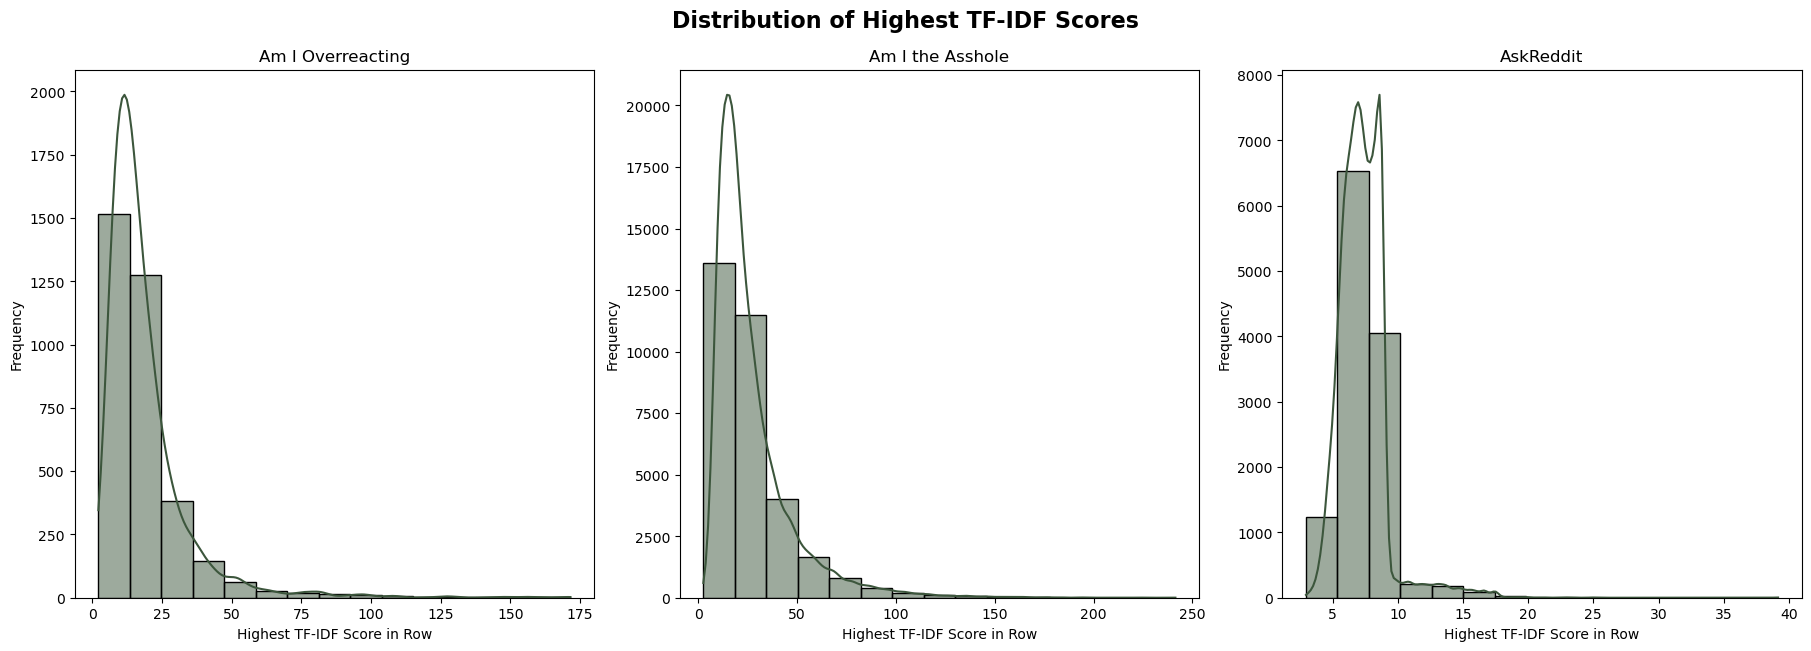

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a single figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Plot for /AIO
sns.histplot(aio_pandas["first_highest_score"], bins=15, kde=True, color="#3c563c", ax=axes[0])
axes[0].set_xlabel("Highest TF-IDF Score in Row")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Am I Overreacting")

# Plot for /AITA
sns.histplot(aita_pandas["first_highest_score"], bins=15, kde=True, color="#3c563c", ax=axes[1])
axes[1].set_xlabel("Highest TF-IDF Score in Row")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Am I the Asshole")

# Plot for /AskReddit
sns.histplot(ask_pandas["first_highest_score"], bins=15, kde=True, color="#3c563c", ax=axes[2])
axes[2].set_xlabel("Highest TF-IDF Score in Row")
axes[2].set_ylabel("Frequency")
axes[2].set_title("AskReddit")

# Save the entire figure
fig.suptitle("Distribution of Highest TF-IDF Scores", fontsize=16, weight='bold', y=1.06)
fig.savefig("../website/images/nlp/highest_tfidf_scores_distribution_combined.png", transparent=True, bbox_inches="tight")  # Save as PNG

plt.show()

/tmp/ipykernel_299/2629961303.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


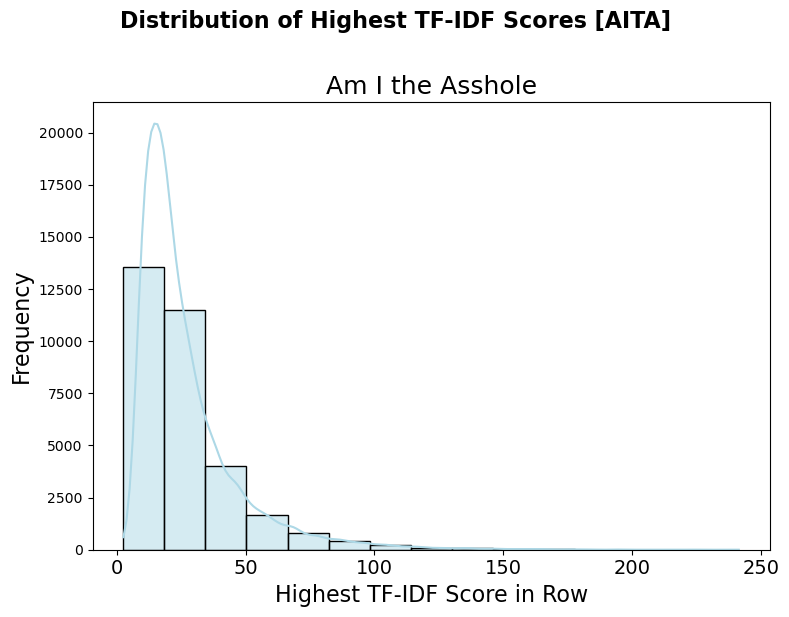

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot for /AITA
sns.histplot(aita_pandas["first_highest_score"], bins=15, kde=True, color="#add8e6", ax=ax)

# Set labels and title
ax.set_xlabel("Highest TF-IDF Score in Row", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Am I the Asshole", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

# Add a main title for the figure
fig.suptitle("Distribution of Highest TF-IDF Scores [AITA]", fontsize=16, weight='bold', y=1.02)

# Adjust layout
plt.tight_layout()

# Uncomment to save the figure
fig.savefig("../website/images/nlp/highest_tfidf_scores_distribution_aita.png", transparent=True, bbox_inches="tight")

# Show the plot
plt.show()

/tmp/ipykernel_299/3364986821.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)  # Use ax instead of axes[1]


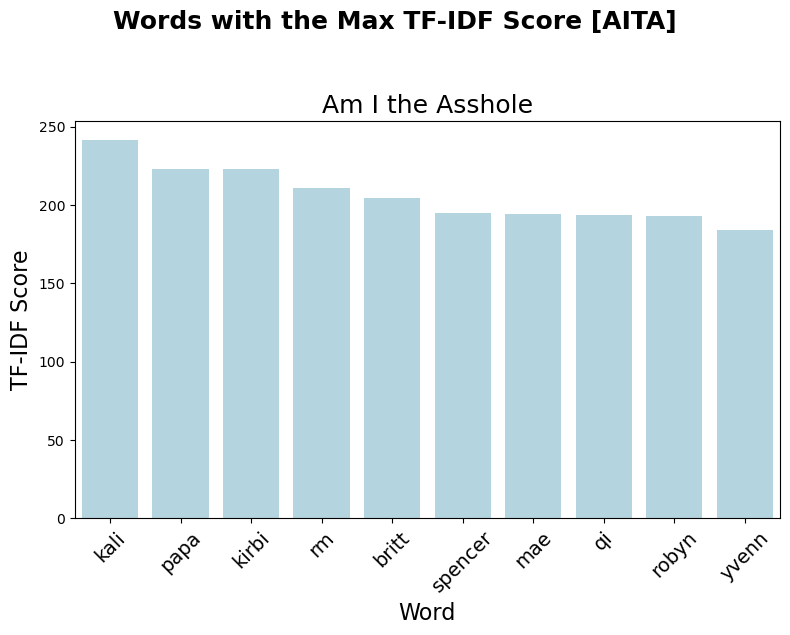

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for /AITA
aita_1 = aita_pandas.sort_values('first_highest_score', ascending=False)

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bar chart
sns.barplot(data=aita_1.head(10), x='first_highest_word', y='first_highest_score', color="#add8e6", ax=ax)

# Customize the plot
ax.set_title('Am I the Asshole', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)  # Use ax instead of axes[1]
ax.set_xlabel('Word', fontsize=16)
ax.set_ylabel('TF-IDF Score', fontsize=16)

# Add a title for the entire figure
fig.suptitle('Words with the Max TF-IDF Score [AITA]', fontsize=18, weight='bold', y=1.05)

# Uncomment to save the figure
fig.savefig("../website/images/nlp/max_score_aita.png", transparent=True, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()


In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create a figure with 1 row and 3 columns
# fig, axes = plt.subplots(1, 3, figsize=(24, 8), constrained_layout=True)

# # Plot for /AIO
# aio_1 = aio_pandas.sort_values('first_highest_score', ascending=False)
# sns.barplot(data=aio_1.head(10), x='first_highest_word', y='first_highest_score', color="#add8e6", ax=axes[0])
# axes[0].set_title('Am I Overreacting', fontsize=18)
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, fontsize=16)
# axes[0].set_xlabel('Word', fontsize=16)
# axes[0].set_ylabel('TF-IDF Score', fontsize=16)

# # Plot for /AITA
# aita_1 = aita_pandas.sort_values('first_highest_score', ascending=False)
# sns.barplot(data=aita_1.head(10), x='first_highest_word', y='first_highest_score', color="#add8e6", ax=axes[1])
# axes[1].set_title('Am I the Asshole', fontsize=18)
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, fontsize=16)
# axes[1].set_xlabel('Word', fontsize=16)
# axes[1].set_ylabel('TF-IDF Score', fontsize=16)

# # Plot for /AskReddit
# ask_1 = ask_pandas.sort_values('first_highest_score', ascending=False)
# sns.barplot(data=ask_1.head(10), x='first_highest_word', y='first_highest_score', color="#add8e6", ax=axes[2])
# axes[2].set_title('AskReddit', fontsize=18)
# axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, fontsize=16)
# axes[2].set_xlabel('Word', fontsize=16)
# axes[2].set_ylabel('TF-IDF Score', fontsize=16)

# # Save the combined plot as a single PNG
# fig.suptitle('Words with the Max TF-IDF Score for Each Dataset', fontsize=18, weight='bold', y=1.05)
# fig.savefig("../website/images/nlp/max_score_combined.png", transparent=True, bbox_inches="tight")

# plt.show()


# AITA TOPIC MODEL COMPARISON

In [16]:
%%time

clean_aio_df_pd = clean_aio_df.toPandas()
clean_aita_df_pd = clean_aita_df.toPandas()
clean_ask_df_pd = clean_ask_df.toPandas()

CPU times: user 300 ms, sys: 96 ms, total: 396 ms
Wall time: 2min 56s


In [17]:
num_topics = 5

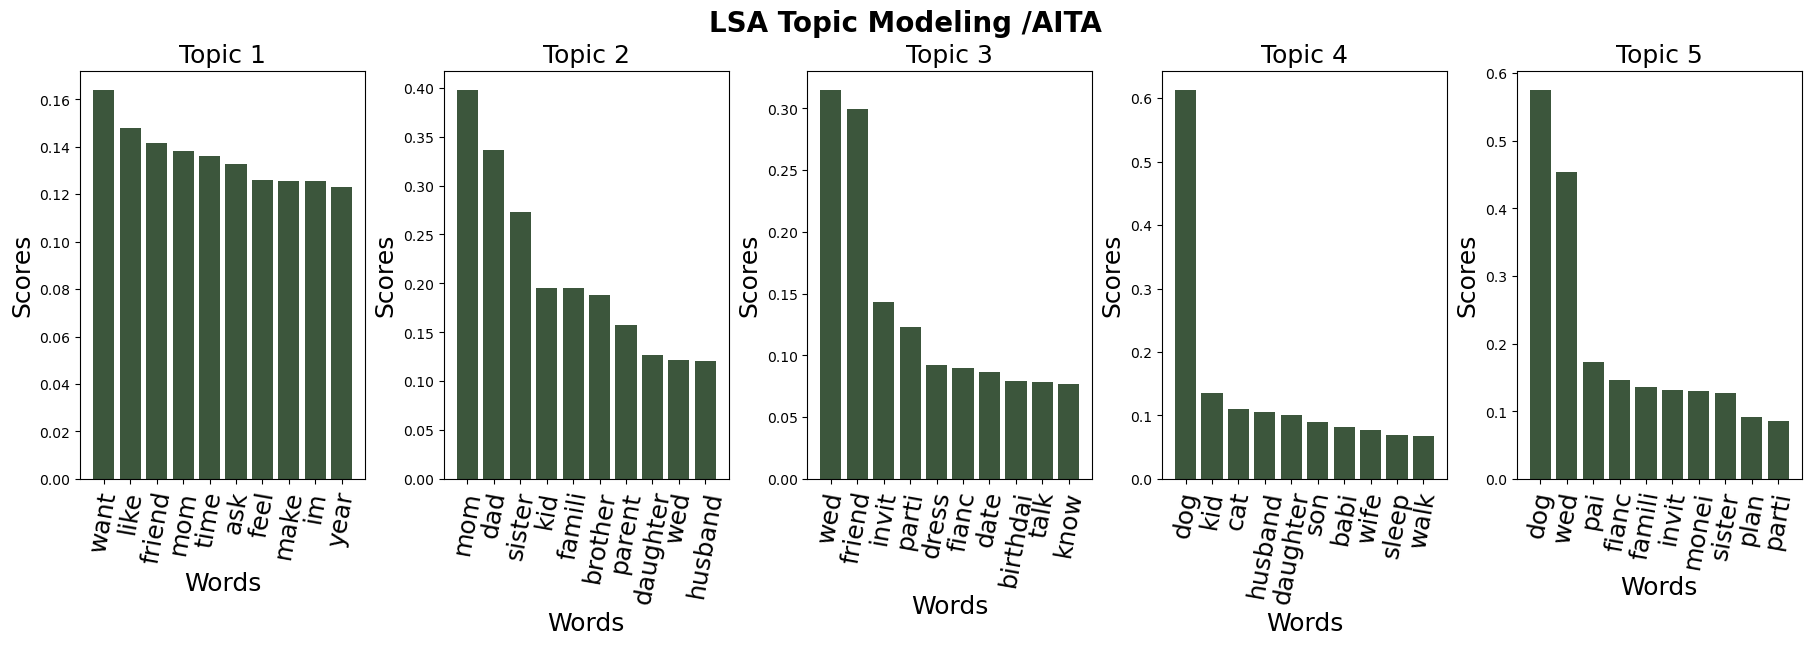

In [71]:
# LSA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df = 0.7, min_df = 5)
tfidf_matrix = vectorizer.fit_transform(clean_aita_df_pd['final_cleaned_text'])

# Define the number of topics
# num_topics = 5  # Adjust based on your needs
lsa_model_aita = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_topics_aita = lsa_model_aita.fit_transform(tfidf_matrix)

terms = vectorizer.get_feature_names_out()
topic_words = {}

for i, topic in enumerate(lsa_model_aita.components_):
    top_indices = topic.argsort()[-10:][::-1]  # Top 10 terms for the topic
    top_terms = [terms[j] for j in top_indices]
    top_scores = topic[top_indices]
    topic_words[f"Topic {i+1}"] = list(zip(top_terms, top_scores))

# Plotting all topics in vertically stacked subplots
fig, axes = plt.subplots(nrows=1, ncols=num_topics, figsize=(18, 6), constrained_layout=True)

for i, (topic, words_scores) in enumerate(topic_words.items()):
    words, scores = zip(*words_scores)
    axes[i].bar(words, scores, color="#3c563c")
    axes[i].set_title(topic, fontsize=18)
    axes[i].set_xlabel("Words", fontsize = 18)
    axes[i].set_ylabel("Scores", fontsize = 18)
    axes[i].tick_params(axis='x', rotation=80, labelsize=18)

fig.suptitle('LSA Topic Modeling /AITA', fontsize=20, weight='bold', y=1.05)
fig.savefig("../website/images/nlp/LSA_AITA.png", transparent=True, bbox_inches="tight")  # Save as PNG
plt.show()

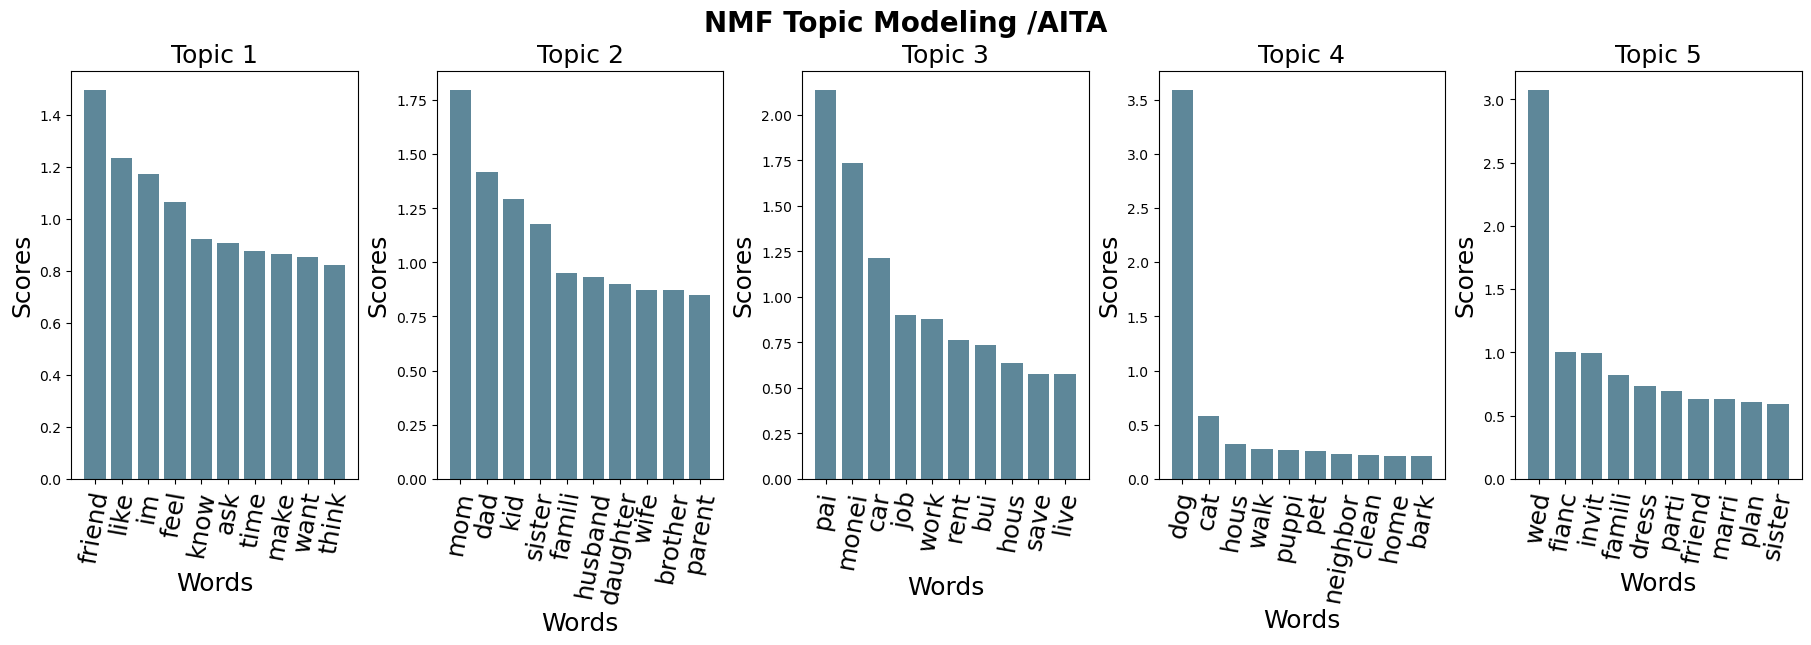

In [72]:
# NMF
from sklearn.decomposition import NMF

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df = 0.7, min_df = 5)
tfidf_matrix = vectorizer.fit_transform(clean_aita_df_pd['final_cleaned_text'])

# Define the number of topics
# num_topics = 5  # Adjust based on your needs

nmf_model_aita = NMF(n_components=num_topics, random_state=42, max_iter=200)
nmf_topics_aita = nmf_model_aita.fit_transform(tfidf_matrix)

# Get top words for each topic
terms = vectorizer.get_feature_names_out()
nmf_topic_words = {}

for i, topic in enumerate(nmf_model_aita.components_):
    top_indices = topic.argsort()[-10:][::-1]  # Top 10 terms for the topic
    top_terms = [terms[j] for j in top_indices]
    top_scores = topic[top_indices]
    nmf_topic_words[f"Topic {i+1}"] = list(zip(top_terms, top_scores))

# Plotting all topics in vertically stacked subplots
fig, axes = plt.subplots(nrows=1, ncols=num_topics, figsize=(18, 6), constrained_layout=True)

for i, (topic, words_scores) in enumerate(nmf_topic_words.items()):
    words, scores = zip(*words_scores)
    axes[i].bar(words, scores, color="#5E8799")
    axes[i].set_title(topic, fontsize=18)
    axes[i].set_xlabel("Words", fontsize = 18)
    axes[i].set_ylabel("Scores", fontsize = 18)
    axes[i].tick_params(axis='x', rotation=80, labelsize=18)

fig.suptitle('NMF Topic Modeling /AITA', fontsize=20, weight='bold', y=1.05)
fig.savefig("../website/images/nlp/NMF_AITA.png", transparent=True, bbox_inches="tight")  # Save as PNG
plt.show()


In [60]:
clean_aita_df_pd['nmf_topic'] = nmf_topics_aita.argmax(axis=1)+1
clean_aita_df_pd['lsa_topic'] = lsa_topics_aita.argmax(axis=1)+1

print(clean_aita_df_pd.groupby(['nmf_topic']).size().reset_index())
print(clean_aita_df_pd.groupby(['lsa_topic']).size().reset_index())

   nmf_topic      0
0          1  14080
1          2   9448
2          3   4966
3          4   1423
4          5   2482
   lsa_topic      0
0          1  31227
1          2    175
2          3     83
3          4    583
4          5    331


In [61]:
clean_aita_df_pd[['post_id','nmf_topic']].head()

,post_id,nmf_topic
0,19ffwqt,4
1,1e8mf01,1
2,18oistj,2
3,1dz7ife,1
4,189xgsf,1


In [62]:
clean_aita_df_pd.head()

,post_id,selftext,final_cleaned_text,nmf_topic,lsa_topic
0,19ffwqt,Hey guys. My girlfriend and I have dated for a...,hei gui girlfriend date around year live separ...,4,1
1,1e8mf01,My sister (27F) calls me (24F) at least once a...,sister f call f least month ask watch niec f e...,1,1
2,18oistj,I (33F) live a long distance away from my home...,f live long distanc awai hometown parent great...,2,1
3,1dz7ife,I (F18) and many others were waiting for the e...,f mani other wait elev come front woman call a...,1,1
4,189xgsf,I (F18) was in my room last night when I saw m...,f room last night see brother m camera hide bo...,1,1


# NMF on aio and askreddit

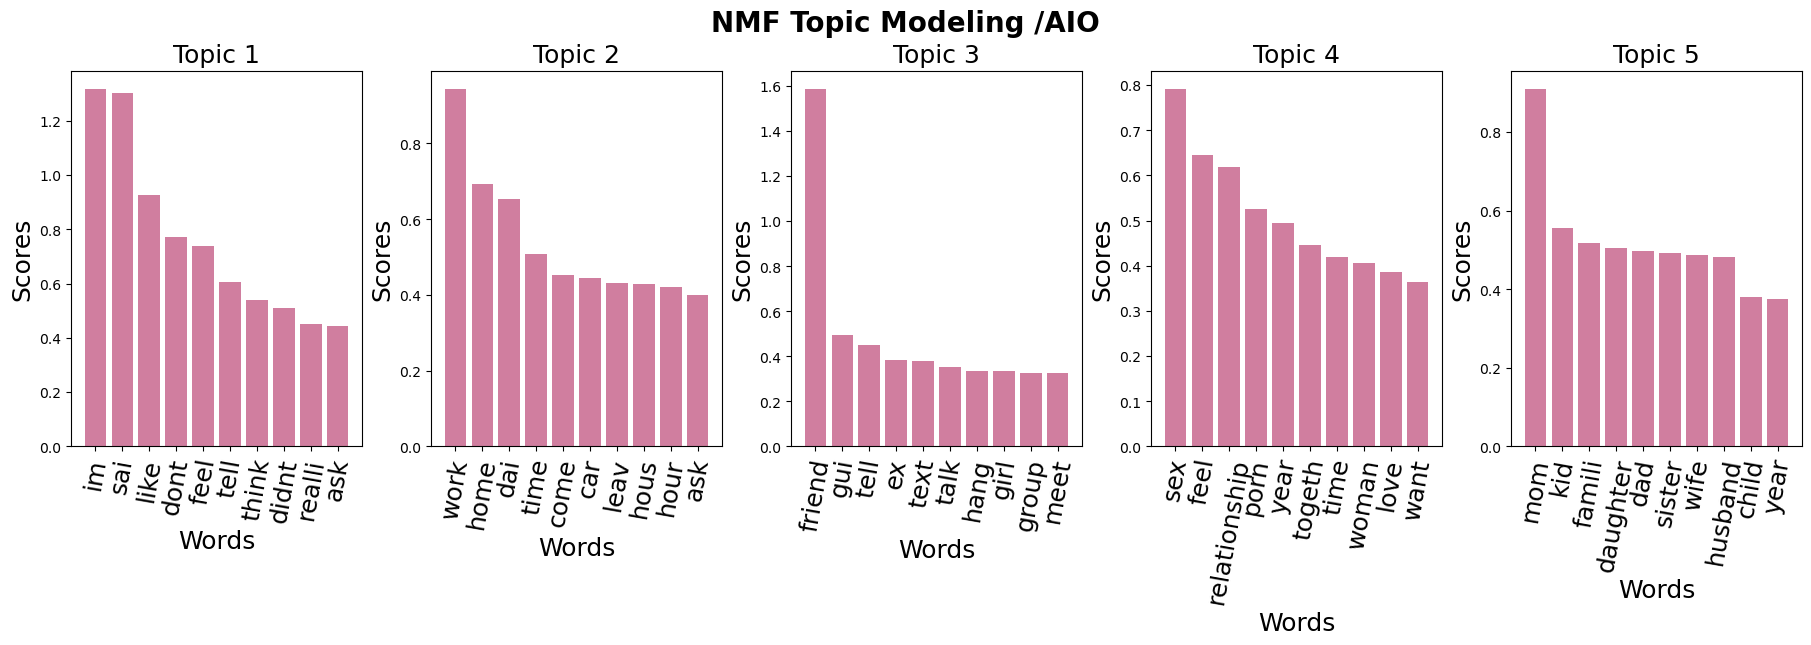

In [73]:
# NMF
from sklearn.decomposition import NMF

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df = 0.9, min_df = 5)
tfidf_matrix = vectorizer.fit_transform(clean_aio_df_pd['final_cleaned_text'])

# Define the number of topics
# num_topics = 3  # Adjust based on your needs

nmf_model_aio = NMF(n_components=num_topics, random_state=42, max_iter=200)
nmf_topics_aio = nmf_model_aio.fit_transform(tfidf_matrix)

# Get top words for each topic
terms = vectorizer.get_feature_names_out()
nmf_topic_words = {}

for i, topic in enumerate(nmf_model_aio.components_):
    top_indices = topic.argsort()[-10:][::-1]  # Top 10 terms for the topic
    top_terms = [terms[j] for j in top_indices]
    top_scores = topic[top_indices]
    nmf_topic_words[f"Topic {i+1}"] = list(zip(top_terms, top_scores))

# Plotting all topics in vertically stacked subplots
fig, axes = plt.subplots(nrows=1, ncols=num_topics, figsize=(18, 6), constrained_layout=True)

for i, (topic, words_scores) in enumerate(nmf_topic_words.items()):
    words, scores = zip(*words_scores)
    axes[i].bar(words, scores, color="#D07E9F")
    axes[i].set_title(topic, fontsize=18)
    axes[i].set_xlabel("Words", fontsize = 18)
    axes[i].set_ylabel("Scores", fontsize = 18)
    axes[i].tick_params(axis='x', rotation=80, labelsize=18)

fig.suptitle('NMF Topic Modeling /AIO', fontsize=20, weight='bold', y=1.05)
fig.savefig("../website/images/nlp/NMF_AIO.png", transparent=True, bbox_inches="tight")  # Save as PNG
plt.show()


In [64]:
clean_aio_df_pd['nmf_topic'] = nmf_topics_aio.argmax(axis=1)+1
# clean_aio_df_pd['lsa_topic'] = lsa_topics_aio.argmax(axis=1)+1

print(clean_aio_df_pd.groupby(['nmf_topic']).size().reset_index())
# print(clean_aio_df_pd.groupby(['lsa_topic']).size().reset_index())

   nmf_topic    0
0          1  771
1          2  712
2          3  624
3          4  699
4          5  663


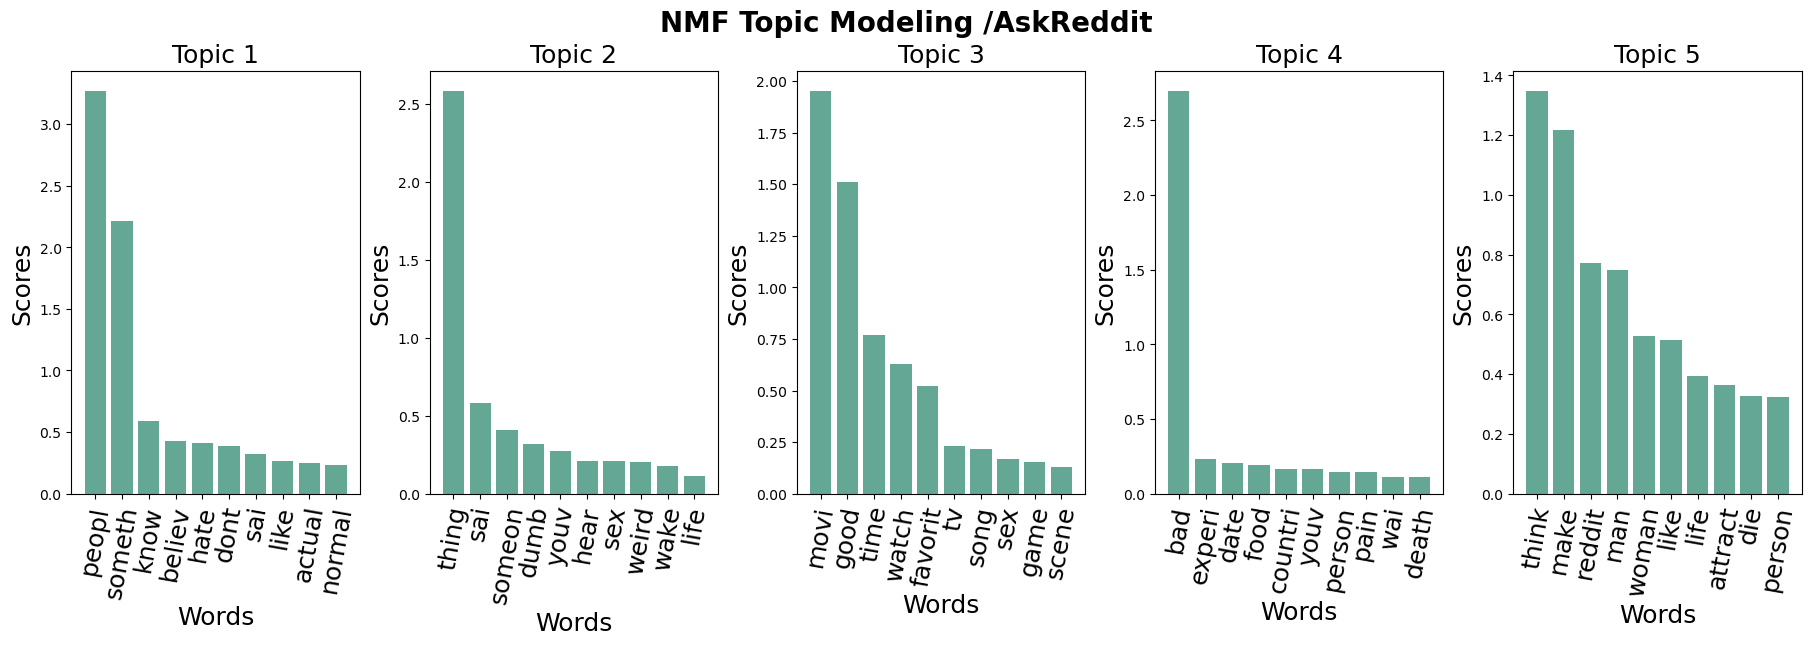

In [74]:
# NMF
from sklearn.decomposition import NMF

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(clean_ask_df_pd['final_cleaned_text'])

# Define the number of topics
# num_topics = 3  # Adjust based on your needs

nmf_model_ask = NMF(n_components=num_topics, random_state=42, max_iter=200)
nmf_topics_ask = nmf_model_ask.fit_transform(tfidf_matrix)

# Get top words for each topic
terms = vectorizer.get_feature_names_out()
nmf_topic_words = {}

for i, topic in enumerate(nmf_model_ask.components_):
    top_indices = topic.argsort()[-10:][::-1]  # Top 10 terms for the topic
    top_terms = [terms[j] for j in top_indices]
    top_scores = topic[top_indices]
    nmf_topic_words[f"Topic {i+1}"] = list(zip(top_terms, top_scores))

# Plotting all topics in vertically stacked subplots
fig, axes = plt.subplots(nrows=1, ncols=num_topics, figsize=(18, 6), constrained_layout=True)

for i, (topic, words_scores) in enumerate(nmf_topic_words.items()):
    words, scores = zip(*words_scores)
    axes[i].bar(words, scores, color="#65A795")
    axes[i].set_title(topic, fontsize=18)
    axes[i].set_xlabel("Words", fontsize = 18)
    axes[i].set_ylabel("Scores", fontsize = 18)
    axes[i].tick_params(axis='x', rotation=80, labelsize=18)

fig.suptitle('NMF Topic Modeling /AskReddit', fontsize=20, weight='bold', y=1.05)
fig.savefig("../website/images/nlp/NMF_ASK.png", transparent=True, bbox_inches="tight")  # Save as PNG
plt.show()

# Dear Abby

In [26]:
import pandas as pd
da = pd.read_csv('./../data/csv/raw_da_qs.csv')

In [27]:
da.head()

,index,year,month,day,url,title,letterId,question_only
0,0,1985,1.0,01,proquest,WOMAN NEEDS HELP: HER BURDEN OF HOPELESSNESS I...,1,i have been in a bad marriage for 40 years. i ...
1,1,1985,1.0,01,proquest,WOMAN NEEDS HELP: HER BURDEN OF HOPELESSNESS I...,1,"this is for all newspaper carriers, mail carri..."
2,2,1985,1.0,02,proquest,LAMENT ABOUT OLD AGE AND SICKNESS IS ILL-ADVISED,1,our 16-year-old son recently was placed in a s...
3,3,1985,1.0,03,proquest,'NORMAL' WIDOW HAS AN EYE FOR THE GUYS,1,"i was a happy, respectable wife for 40 years, ..."
4,4,1985,1.0,04,proquest,IT'S WISE TO BE WARY WHEN A STRANGER COMES TO ...,1,you be the judge: last night about 7 p.m. i wa...


In [28]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

# Ensure necessary NLTK data files are available
nltk.download('punkt')
nltk.download('stopwords')

# Define the cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords and apply stemming
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    cleaned_words = [ps.stem(word) for word in words if word.isalnum() and word not in stop_words]
    # Join the cleaned words back into a string
    return ' '.join(cleaned_words)

da['final_cleaned_text'] = da['question_only'].apply(clean_text)

[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


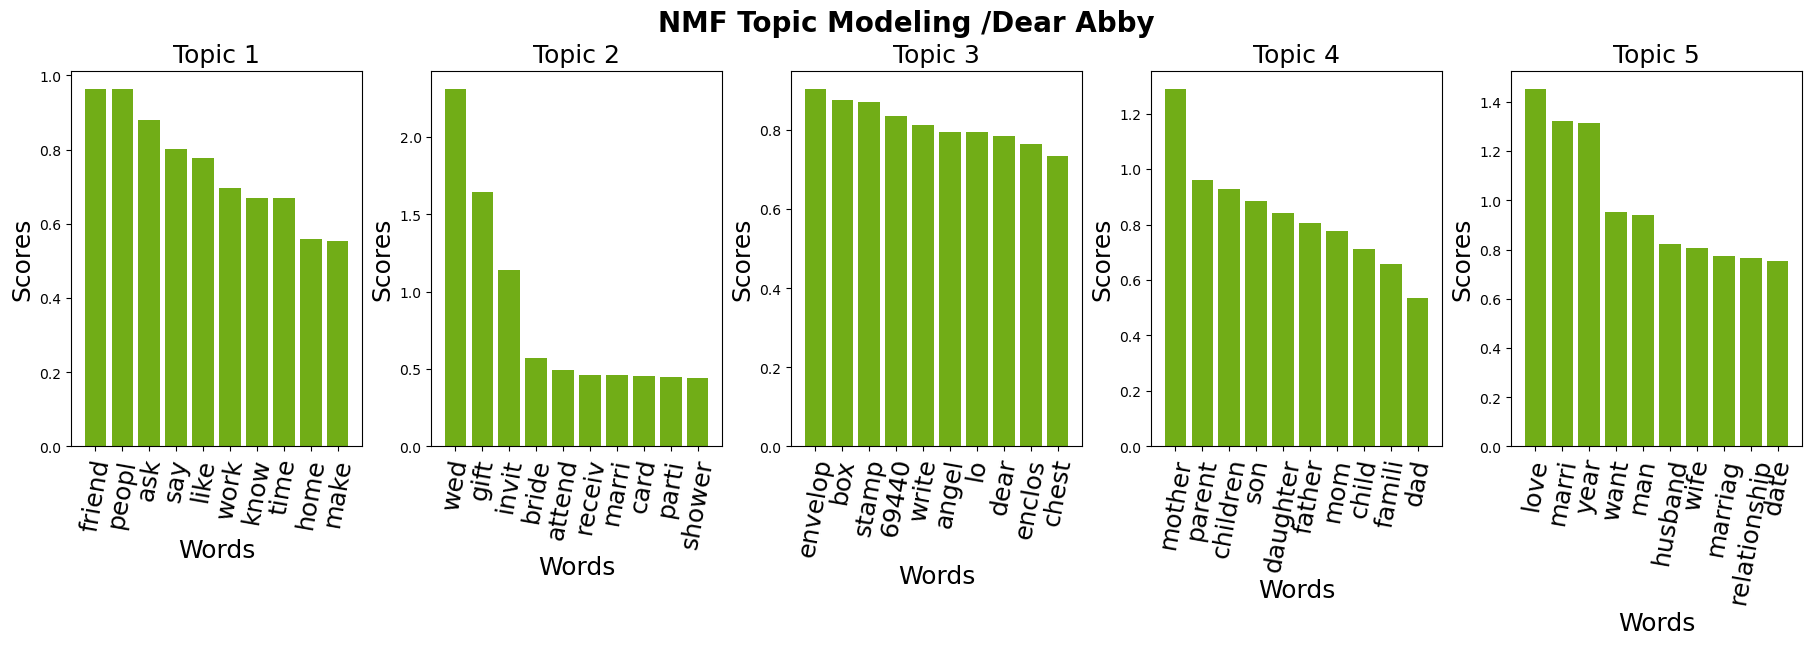

In [75]:
# NMF
from sklearn.decomposition import NMF

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(da['final_cleaned_text'])

# Define the number of topics
# num_topics = 3  # Adjust based on your needs

nmf_model_da = NMF(n_components=num_topics, random_state=42, max_iter=200)
nmf_topics_da = nmf_model_da.fit_transform(tfidf_matrix)

# Get top words for each topic
terms = vectorizer.get_feature_names_out()
nmf_topic_words = {}

for i, topic in enumerate(nmf_model_da.components_):
    top_indices = topic.argsort()[-10:][::-1]  # Top 10 terms for the topic
    top_terms = [terms[j] for j in top_indices]
    top_scores = topic[top_indices]
    nmf_topic_words[f"Topic {i+1}"] = list(zip(top_terms, top_scores))

# Plotting all topics in vertically stacked subplots
fig, axes = plt.subplots(nrows=1, ncols=num_topics, figsize=(18, 6), constrained_layout=True)

for i, (topic, words_scores) in enumerate(nmf_topic_words.items()):
    words, scores = zip(*words_scores)
    axes[i].bar(words, scores, color="#71ad17")
    axes[i].set_title(topic, fontsize=18)
    axes[i].set_xlabel("Words", fontsize = 18)
    axes[i].set_ylabel("Scores", fontsize = 18)
    axes[i].tick_params(axis='x', rotation=80, labelsize=18)

fig.suptitle('NMF Topic Modeling /Dear Abby', fontsize=20, weight='bold', y=1.05)
fig.savefig("../website/images/nlp/NMF_DA.png", transparent=True, bbox_inches="tight")  # Save as PNG
plt.show()

In [30]:
da['nmf_topic'] = nmf_topics_da.argmax(axis=1)+1
print(da.groupby(['nmf_topic']).size().reset_index())

   nmf_topic     0
0          1  7948
1          2  1883
2          3   792
3          4  5288
4          5  4123


In [31]:
topic_mapping = {
    1: 'friends',
    2: 'wedding',
    3: 'package',
    4: 'family',
    5: 'marriage'
}

# Map the nmf_topics to their corresponding categories
da['topic_category'] = da['nmf_topic'].map(topic_mapping)

# Sentiment

In [32]:
# aita_df_sub = aita_df.select("post_id", "selftext").distinct()
# aio_df_sub = aio_df.select("post_id", "selftext").distinct()

In [33]:
%%time

from pyspark.sql.functions import col
from sparknlp.pretrained import PretrainedPipeline
pipeline = PretrainedPipeline("analyze_sentiment", lang="en")


from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

# Map sentiment labels to numeric scores: positive = 1, neutral = 0, negative = -1
sentiment_mapping = {
    "positive": 1.0,
    "neutral": 0.0,
    "negative": -1.0
}

# UDF to convert sentiment labels to numeric scores
def sentiment_to_score(sentiments):
    scores = [sentiment_mapping.get(sent, 0.0) for sent in sentiments]
    return float(sum(scores)) / len(scores) if scores else 0.0

# Register UDF
sentiment_to_score_udf = F.udf(sentiment_to_score, FloatType())

def average_sentiment_score(df):
    # Calculate the average sentiment score
    df = df.withColumn("sentiment_score", sentiment_to_score_udf("sentiment.result"))

    # Classify overall sentiment based on the average score
    df = df.withColumn(
        "overall_sentiment",
        F.when(F.col("sentiment_score") > 0, "positive")
        .when(F.col("sentiment_score") < 0, "negative")
        .otherwise("neutral")
    )
    
    return df

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[ / ]analyze_sentiment download started this may take some time.
Approximate size to download 4.9 MB
[ — ]Download done! Loading the resource.


[OK!]
CPU times: user 59.5 ms, sys: 12 ms, total: 71.6 ms
Wall time: 16.4 s


In [34]:
# Show the results
aio_rename = aio_df_sub.select("post_id",col("selftext").alias("text"))
result_aio = pipeline.transform(aio_rename)
result_aio= average_sentiment_score(result_aio)

aita_rename = aita_df_sub.select("post_id",col("selftext").alias("text"))
result_aita = pipeline.transform(aita_rename)
result_aita= average_sentiment_score(result_aita)

In [35]:
aio_sentiment_pd = result_aio.select("post_id", "overall_sentiment", "sentiment_score").toPandas()
aita_sentiment_pd = result_aita.select("post_id", "overall_sentiment", "sentiment_score").toPandas()

In [36]:
aita_sentiment_pd = result_aita.select("post_id", "overall_sentiment", "sentiment_score").toPandas()

In [37]:
aita_sentiment_pd.head()

,post_id,overall_sentiment,sentiment_score
0,19ffwqt,negative,-0.176471
1,1e8mf01,negative,-0.272727
2,18oistj,negative,-0.032258
3,1dz7ife,negative,-0.677419
4,189xgsf,negative,-0.066667


In [38]:
aita_output = aita_sentiment_pd.merge(clean_aita_df_pd[['post_id','nmf_topic']], on='post_id',how='left')
aio_output = aio_sentiment_pd.merge(clean_aio_df_pd[['post_id','nmf_topic']], on='post_id',how='left')

In [39]:
aio_output.to_csv('./aio.csv',index=False)
aita_output.to_csv('./aita.csv',index=False)

# In depth Analysis

In [40]:
%%time

from pyspark.sql import functions as F

# Step 2: Get the maximum `score_comment` for each `post_id`
max_score_df = aita_df.groupBy("post_id").agg(F.max("score_comment").alias("max_score_comment"))

# Step 3: Join this result back to the filtered DataFrame to get the rows with the highest `score_comment` per `post_id`
aita_df_filtered = aita_df.join(
    max_score_df,
    (aita_df.post_id == max_score_df.post_id) & (aita_df.score_comment == max_score_df.max_score_comment),
    "inner"
).select(aita_df["*"])  # Select all columns from the original DataFrame

# Step 1: Add columns for counts of each term
aita_df_with_counts = aita_df_filtered.withColumn("YTA_count", F.expr("size(split(comment_body, 'YTA')) - 1")) \
                                      .withColumn("NTA_count", F.expr("size(split(comment_body, 'NTA')) - 1")) \
                                      .withColumn("ESH_count", F.expr("size(split(comment_body, 'ESH')) - 1")) \
                                      .withColumn("NAH_count", F.expr("size(split(comment_body, 'NAH')) - 1")) \
                                      .withColumn("INFO_count", F.expr("size(split(comment_body, 'INFO')) - 1"))

# Step 2: Determine the label based on the highest count
aita_df_labeled = aita_df_with_counts.withColumn(
    "label",
    F.when(F.col("YTA_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "YTA")
     .when(F.col("NTA_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "NTA")
     .when(F.col("ESH_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "ESH")
     .when(F.col("NAH_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "NAH")
     .when(F.col("INFO_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "INFO")
)

label_df = aita_df_labeled.select('post_id','label').toPandas()

CPU times: user 315 ms, sys: 28 ms, total: 343 ms
Wall time: 50 s


In [41]:
aio = aio_output.merge(aio_meta_pd, on='post_id',how='left')
aita = aita_output.merge(aita_meta_pd, on='post_id',how='left')
aita = aita.merge(label_df,on='post_id',how='left')

In [42]:
aita['datetime'] = pd.to_datetime(aita['created_utc_post'], unit='s')

# Create columns for yyyy-mm and yyyy-mm-dd
aita['year_month'] = aita['datetime'].dt.to_period('M').astype(str)
aita['date'] = aita['datetime'].dt.strftime('%Y-%m-%d')
aita['hour'] = aita['datetime'].dt.hour

topic_mapping = {
    1: 'friends',
    2: 'family',
    3: 'money',
    4: 'pet',
    5: 'wedding'
}

# Map the nmf_topics to their corresponding categories
aita['topic_category'] = aita['nmf_topic'].map(topic_mapping)

In [43]:
aita.head()

,post_id,overall_sentiment,sentiment_score,nmf_topic,created_utc_post,score_post,num_comments,over_18,label,datetime,year_month,date,hour,topic_category
0,19ffwqt,negative,-0.176471,4,1706206728,1699,1253,False,NTA,2024-01-25 18:18:48,2024-01,2024-01-25,18,pet
1,1e8mf01,negative,-0.272727,1,1721568742,254,102,False,YTA,2024-07-21 13:32:22,2024-07,2024-07-21,13,friends
2,18oistj,negative,-0.032258,2,1703262447,386,54,False,NTA,2023-12-22 16:27:27,2023-12,2023-12-22,16,family
3,1dz7ife,negative,-0.677419,1,1720544365,147,28,False,ESH,2024-07-09 16:59:25,2024-07,2024-07-09,16,friends
4,189xgsf,negative,-0.066667,1,1701621968,1211,606,False,NTA,2023-12-03 16:46:08,2023-12,2023-12-03,16,friends


In [44]:
# # Group by 'year_month' and 'label' to calculate the average sentiment
# test = aita.groupby(['year_month', 'topic_category'])['sentiment_score'].mean().reset_index()

# # Plotting
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=test, x='year_month', y='sentiment_score', hue='topic_category', marker='o', palette='Set2')
# plt.title('Monthly Average Sentiment by Label [AITA]')
# plt.xlabel('Year')
# plt.ylabel('Average Sentiment')
# plt.legend(title='Topic')
# plt.grid(visible=True, axis='y')
# plt.savefig("../website/images/nlp/month_topic_sentiment_aita.png", transparent=True, bbox_inches="tight")
# plt.show()

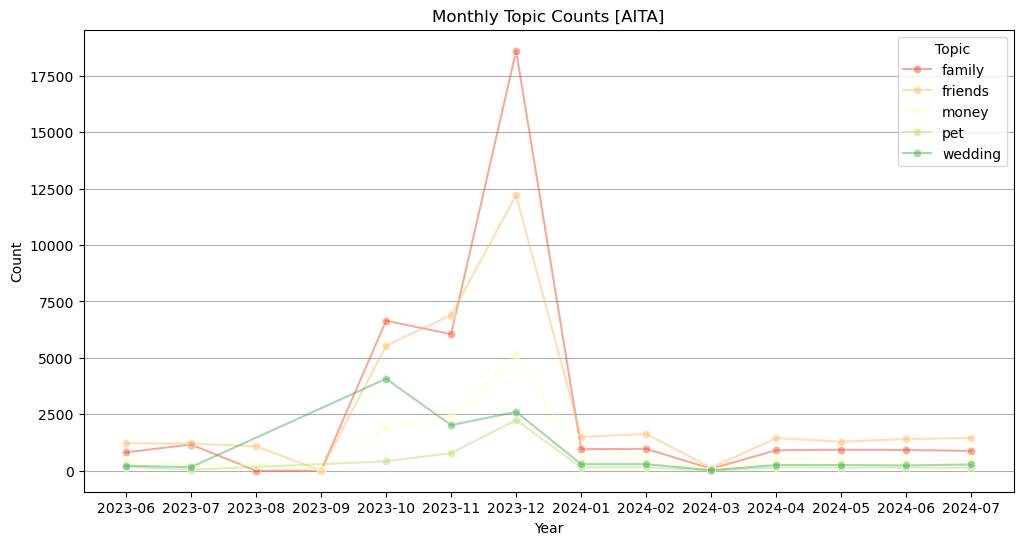

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

test = aita.groupby(['year_month','topic_category']).size().reset_index(name='count')
# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=test, x='year_month', y='count', hue='topic_category', marker='o', palette='RdYlGn', alpha=0.5)
plt.title('Monthly Topic Counts [AITA]')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Topic')
plt.grid(visible=True, axis='y')
plt.savefig("../website/images/nlp/month_topic_count_aita.png", transparent=True, bbox_inches="tight")
plt.show()

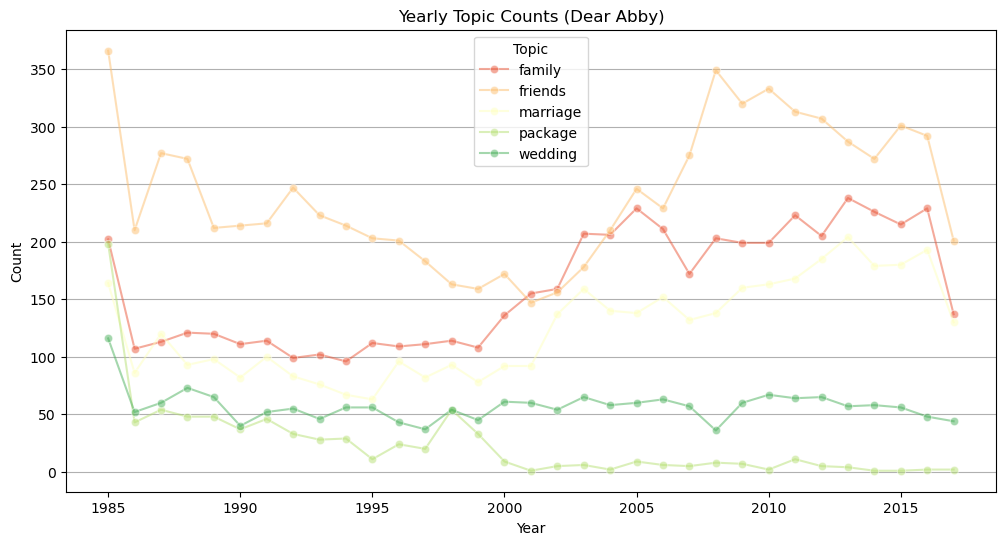

In [69]:
da_plot = da.groupby(['year', 'topic_category']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=da_plot, x='year', y='count', hue='topic_category', marker='o', palette='RdYlGn', alpha = 0.5)
plt.title('Yearly Topic Counts (Dear Abby)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Topic')
plt.grid(visible=True, axis='y')
plt.savefig("../website/images/nlp/year_topic_da.png", transparent=True, bbox_inches="tight")
plt.show()

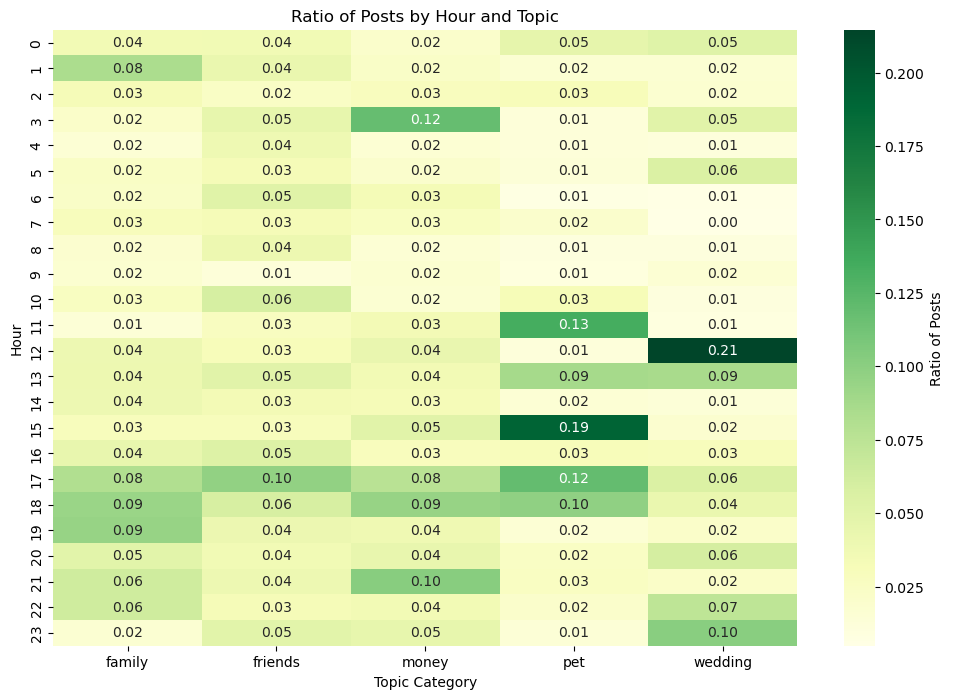

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table to calculate the count of posts for each combination of hour and topic_category
heatmap_data_count = aita.pivot_table(
    index='hour', 
    columns='topic_category', 
    values='post_id',  # 'post_id' is used to count unique posts
    aggfunc='count'
)

# Normalize the data so each column (topic) sums to 1
heatmap_data_ratio = heatmap_data_count.div(heatmap_data_count.sum(axis=0), axis=1)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_ratio, annot=True, cmap='YlGn', fmt=".2f", cbar_kws={'label': 'Ratio of Posts'})
plt.title('Ratio of Posts by Hour and Topic')
plt.xlabel('Topic Category')
plt.ylabel('Hour')
plt.savefig("../website/images/nlp/time_postratio_aita_topic.png", transparent=True, bbox_inches="tight")
plt.show()

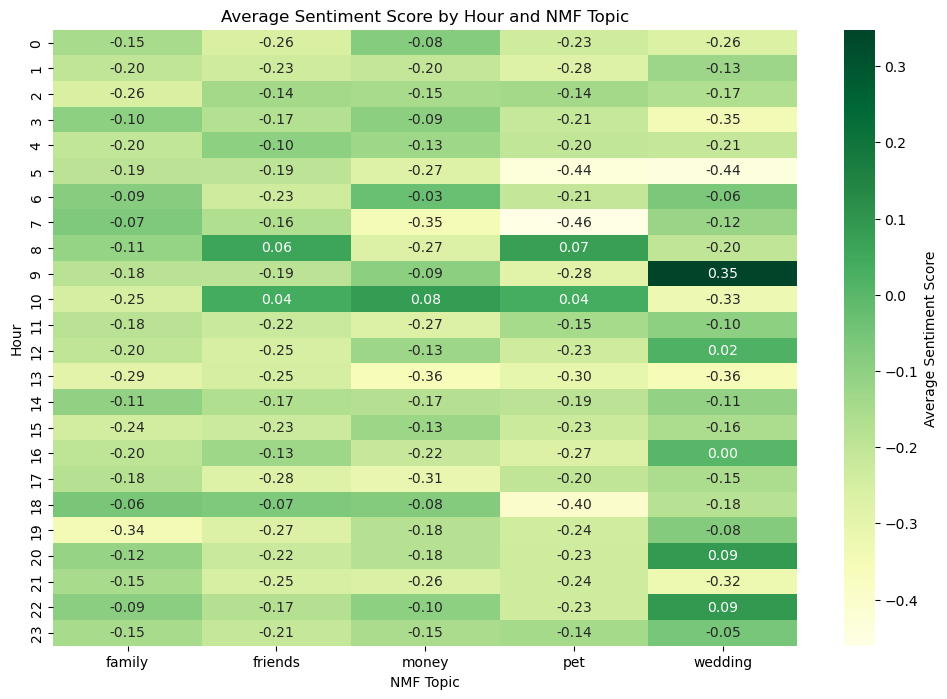

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'aita' is your DataFrame and 'hour' column is added as described earlier
aita['hour'] = aita['datetime'].dt.hour

# Pivot table to calculate average sentiment_score for each combination of hour and nmf_topic
heatmap_data = aita.pivot_table(
    index='hour', 
    columns='topic_category', 
    values='sentiment_score', 
    aggfunc='mean'
)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGn', fmt=".2f", cbar_kws={'label': 'Average Sentiment Score'})
plt.title('Average Sentiment Score by Hour and NMF Topic')
plt.xlabel('NMF Topic')
plt.ylabel('Hour')
plt.savefig("../website/images/nlp/sentiment_time_topic_aita.png", transparent=True, bbox_inches="tight")
plt.show()


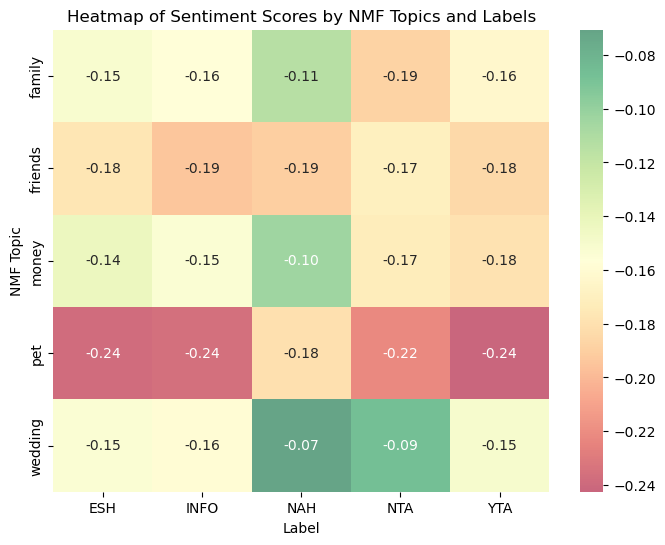

In [49]:
# Create a pivot table for the heatmap
heatmap_data = aita.pivot_table(
    index="topic_category", 
    columns="label", 
    values="sentiment_score", 
    aggfunc="mean"
)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", cbar=True, fmt=".2f", alpha=0.6)
plt.title("Heatmap of Sentiment Scores by NMF Topics and Labels")
plt.xlabel("Label")
plt.ylabel("NMF Topic")
plt.savefig("../website/images/nlp/label_topic_sentiment_aita.png", transparent=True, bbox_inches="tight")
plt.show()

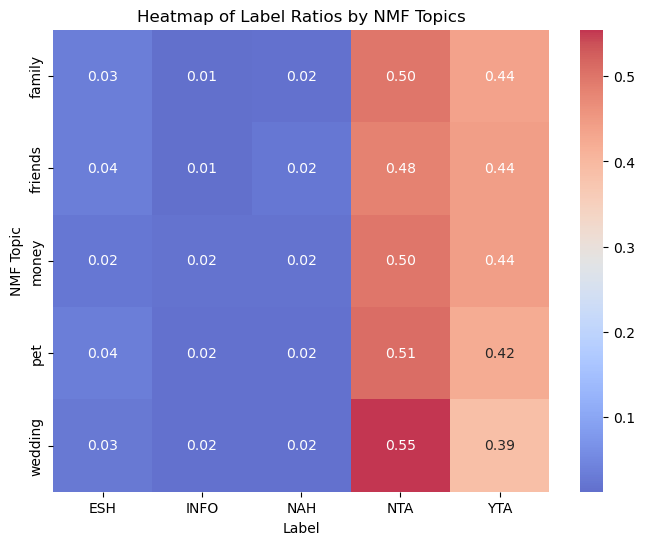

In [50]:
# Create a pivot table for counts
counts = aita.pivot_table(
    index="topic_category", 
    columns="label", 
    aggfunc="size", 
    fill_value=0  # Fill missing values with 0
)

# Normalize counts within each topic to get ratios
ratios = counts.div(counts.sum(axis=1), axis=0)

# Plot the heatmap for ratios
plt.figure(figsize=(8, 6))
sns.heatmap(ratios, annot=True, cmap="coolwarm", cbar=True, fmt=".2f", alpha=0.8)
plt.title("Heatmap of Label Ratios by NMF Topics")
plt.xlabel("Label")
plt.ylabel("NMF Topic")
plt.savefig("../website/images/nlp/label_topic_ratio_aita.png", transparent=True, bbox_inches="tight")
plt.show()



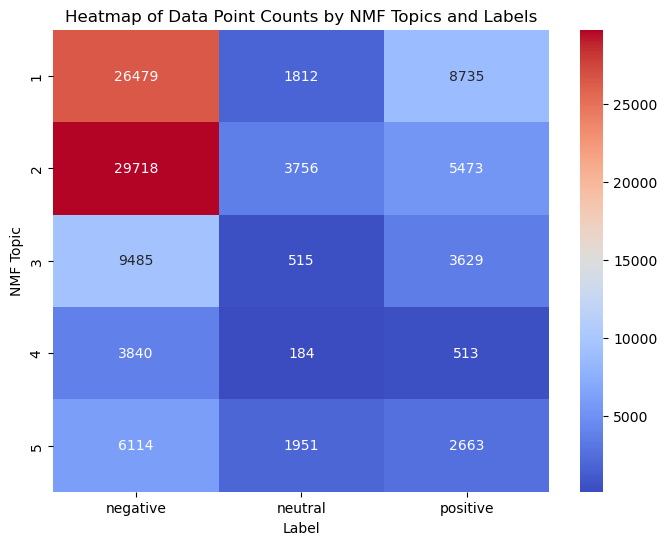

In [51]:
# Create a pivot table for counts based on occurrences of data points
heatmap_data_counts = aita.pivot_table(
    index="nmf_topic", 
    columns="overall_sentiment", 
    aggfunc="size",  # Count the occurrences of data points
    fill_value=0     # Fill missing values with 0
)

# Plot the heatmap for counts
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_counts, annot=True, cmap="coolwarm", cbar=True, fmt="d")
plt.title("Heatmap of Data Point Counts by NMF Topics and Labels")
plt.xlabel("Label")
plt.ylabel("NMF Topic")
plt.show()
